In [1]:
import itertools
import math
import gzip

import pandas
import matplotlib.pyplot as plt
import seaborn
import numpy
import scipy

%matplotlib inline

In [2]:
commit = '3e87872db5fca5ac427ce27464ab945c0ceb4ec6' #commit code is unique to this data

# Read subset of DrugBank compounds
url = 'https://raw.githubusercontent.com/dhimmel/drugbank/{}/data/drugbank-slim.tsv'.format(commit)
drugbank_df = pandas.read_table(url)
drugbank_df.head()

# Read protein-compound relationships
url = 'https://raw.githubusercontent.com/dhimmel/drugbank/{}/data/proteins.tsv'.format(commit)
protein_df = pandas.read_table(url)

# remove rows from protein_df whose drugbank_ids are not in the slim dataset
protein_df = protein_df[protein_df.drugbank_id.isin(drugbank_df.drugbank_id)]
categories = set(protein_df['category'])

In [3]:
def jaccard(set_0, set_1):
    """Jaccard index with two inputs set_0 and set_1"""
    set_0 = set(set_0)
    set_1 = set(set_1)
    total_number = len(set_0 | set_1)
    if total_number == 0:
        return 0
    return len(set_0 & set_1) / float(total_number)

In [4]:
#create dictionary with drugbank_id as key, category as value
#category is also key of inside dictionary with gene value
protein_dict = dict()

for (drugbank_id, category), df in protein_df.groupby(['drugbank_id', 'category']):
    category_dict = protein_dict.setdefault(drugbank_id, dict())
    category_dict[category] = set(df.entrez_gene_id)

In [6]:
rows= list()

for compound_0, compound_1 in itertools.combinations(protein_dict, 2):
    for category in categories:
        genes_0 = protein_dict[compound_0].get(category, set())
        genes_1 = protein_dict[compound_1].get(category, set())
        jc = jaccard(genes_0, genes_1)
        row = compound_0, compound_1, category, jc
        rows.append(row)

jaccard_df = pandas.DataFrame(rows, columns=['compound_0', 'compound_1', 'category', 'jaccard'])

In [7]:
spread_df = jaccard_df.set_index(['compound_0', 'compound_1', 'category']).unstack().jaccard.reset_index()

996166


/Users/sabrinalchen/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


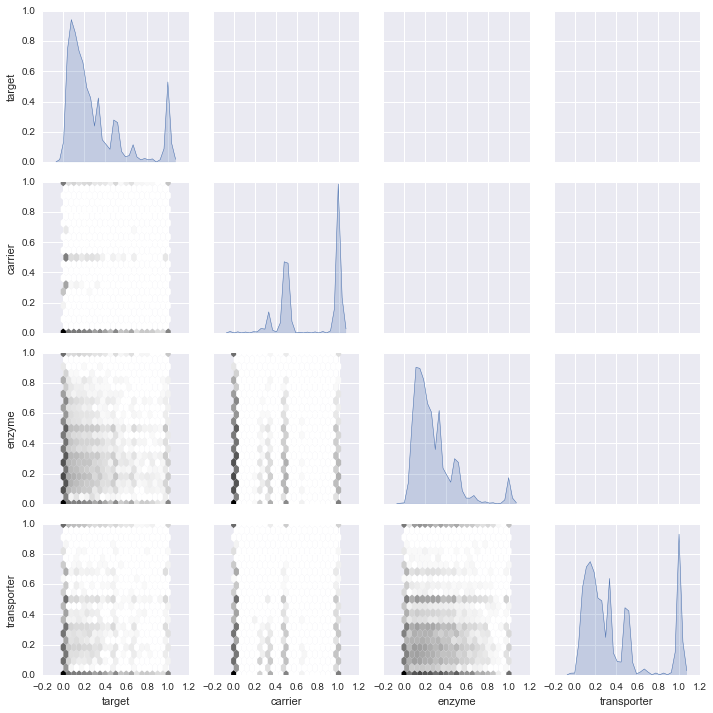

In [8]:
df = spread_df[list(categories)]
print(len(df))
g = seaborn.PairGrid(df, diag_sharey=False)
g.map_lower(plt.hexbin, gridsize=20, bins="log", edgecolor='none')
#bins="log":  log(i+1) is used to determine the hexagon color
g.map_diag(seaborn.kdeplot, lw=5, gridsize=20, shade=True, bw=.0237, linewidth=0.5)

In [9]:
#make all values >0 in table as 1
spread_binary_df = spread_df.copy()
for category in categories:
    spread_binary_df[category] = (spread_binary_df[category] > 0).astype(int)

short_spread_binary_df=spread_binary_df[list(categories)] #extract only category columns

In [10]:
def contingency_table(df):
    """create a contingency table for a dataframe"""
    a = df.iloc[:, 0] > 0
    b = df.iloc[:, 1] > 0
    df = df.groupby([a, b]).count()
    df= df[[0]].unstack()
    df.reset_index(drop=True)
    df.index=['False', 'True']
    df.stack().unstack()
    return df

In [11]:
#make a dictionary of each combination of tuples with the contingency table and p-value as keys
contingency_dict= {}
for pair in itertools.permutations(short_spread_binary_df.columns, 2):
    pair_df = short_spread_binary_df[list(pair)]
    cont_table = contingency_table(pair_df)
    chi2, p, dof, ex = scipy.stats.chi2_contingency(cont_table)
    contingency_dict[pair] = {'contingency_table': cont_table, 'p-value': p, 'chi2': chi2}

In [87]:
freq_dict={}
true_list=[]
false_list=[]
key_list1=[]
key_list2=[]
for key in contingency_dict:
    a = contingency_dict[key]['contingency_table']
    false, true = a.iloc[1, :].values / a.sum(axis=0).values
    true_list.append(true)
    false_list.append(false)
    list(key)
    key_list1.append(key[0])
    key_list2.append(key[1])
    freq_dict["True"]=true_list #add all true frequencies to the true_list
    freq_dict["False"]=false_list #add all false frequences to the false_list
    freq_dict["Type1"]=key_list1
    freq_dict["Type2"]=key_list2

In [88]:
freq_df = pandas.DataFrame(data=freq_dict)
freq_df = freq_df[["Type1", 'Type2', 'True', 'False']]

In [89]:
freq_df=pandas.melt(freq_df, id_vars=['Type1', 'Type2'], value_vars=['True', 'False'])
freq_df.columns=['Type1', 'Type2', 'T_or_F', 'value']
freq_df = freq_df.iloc[::-1]

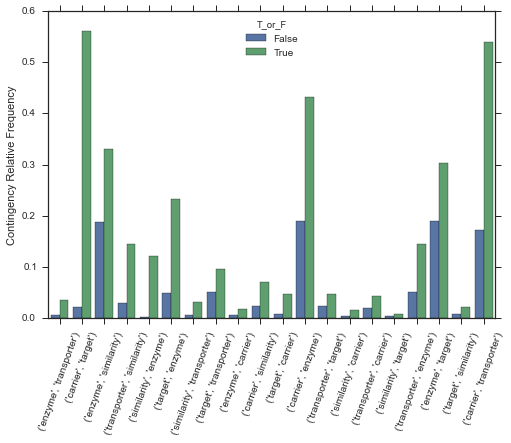

In [90]:
x=freq_df[['Type1', 'Type2']].apply(tuple, axis=1)
freq_barplot=seaborn.barplot(x, y=freq_df['value'], hue=freq_df['T_or_F'])
freq_barplot.set_xticklabels(x, rotation=70) #rotate text
ax= freq_barplot.set_ylabel("Contingency Relative Frequency")

In [16]:
#open and read the similarities table
gz=gzip.open('/Users/sabrinalchen/Downloads/similarity.tsv.gz')
similarities_df = pandas.read_table(gz)
similarities_df.columns = ['compound_0', 'compound_1', 'similarity']

In [115]:
#merge the orginal compound dataframe with the similarity dataframe
#note: the merge will only take rows of overlapping compound pairs
simi_jaccard_df=pandas.merge(spread_df, similarities_df)
simi_jaccard_df=simi_jaccard_df[['compound_0', 'compound_1', 'enzyme', 'target', 'carrier', 'transporter', 'similarity']]
short_simi_jaccard_df=simi_jaccard_df[['enzyme', 'target', 'carrier', 'transporter', 'similarity']]

/Users/sabrinalchen/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


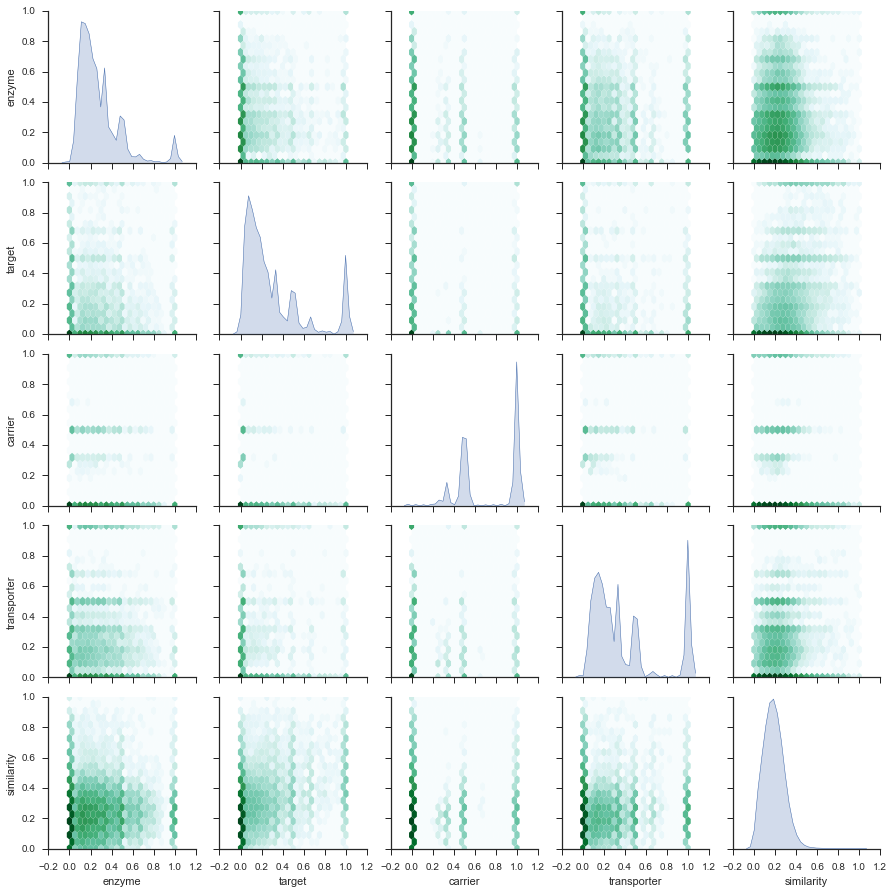

In [212]:
#illustrate new data including the similarity
g = seaborn.PairGrid(simi_jaccard_df, diag_sharey=False, palette="Set2")
g.map_offdiag(plt.hexbin, cmap="BuGn", gridsize=20, bins= "log", edgecolor='none')
#bins="log":  log(i+1) is used to determine the hexagon color
g.map_diag(seaborn.kdeplot, lw=5,gridsize=20, shade=True, bw=.0237, linewidth=0.5)
g.savefig("similarity.png", dpi=200)

In [117]:
#merge the orginial contingency-type table 
spread_cont_df=spread_df.reset_index()
simi_cont_df=pandas.merge(spread_df, similarities_df)
simi_cont_df=simi_cont_df[['compound_0', 'compound_1', 'enzyme', 'target', 'carrier', 'transporter', 'similarity']]

In [118]:
#change the vales in the similarity column to contingency values
simi_cont_df2=((simi_cont_df.loc[:,'similarity'] < 0.5) == 0)
simi_cont_df2=((simi_cont_df.loc[:,'similarity'] > 0.5) == 1)
simi_cont_df.similarity=simi_cont_df2

In [119]:
#delete the compound_0 and compound_1
simi_cont_short_df=simi_cont_df[['enzyme', 'target', 'carrier', 'transporter', 'similarity']]

In [120]:
#make a dictionary of each combination of tuples with the contingency table and p-value as keys
contingency_dict= {}
p_value=[]
for pair in itertools.permutations(simi_cont_short_df.columns, 2):
    pair_df = simi_cont_short_df[list(pair)]
    cont_table = contingency_table(pair_df)
    chi2, p, dof, ex = scipy.stats.chi2_contingency(cont_table)
    p_value.append(p)
    p_value.append(p)
    contingency_dict[pair] = {'contingency_table': cont_table, 'p-value': p, 'chi2': chi2}

In [170]:
#make a dictionary of True and False lists along with the Types of categories
freq_dict={}
true_list=[]
false_list=[]
key_list1=[]
key_list2=[]
for key in contingency_dict:
    a = contingency_dict[key]['contingency_table']
    false, true = a.iloc[1, :].values / a.sum(axis=0).values
    true_list.append(true)
    false_list.append(false)
    list(key)
    key_list1.append(key[0])
    key_list2.append(key[1])
    freq_dict["True"]=true_list #add all true frequencies to the true_list
    freq_dict["False"]=false_list #add all false frequences to the false_list
    freq_dict["Type1"]=key_list1
    freq_dict["Type2"]=key_list2

In [171]:
#create dataframe using the freqency dict
new_freq_df = pandas.DataFrame(data=freq_dict)
new_freq_df = new_freq_df[["Type1", 'Type2', 'True', 'False']] #rename the columns 

In [172]:
#melt the False and True columns
new_freq_df=pandas.melt(new_freq_df, id_vars=['Type1', 'Type2'], value_vars=['True', 'False'])
new_freq_df.columns=['Type1', 'Type2', 'T_or_F', 'contingency_relative_frequency']
new_freq_df = new_freq_df.sort("T_or_F")
new_freq_df['contingency_relative_frequency']= new_freq_df['contingency_relative_frequency']*100
new_freq_df

,Type1,Type2,T_or_F,contingency_relative_frequency
39,carrier,transporter,False,0.630494
20,enzyme,transporter,False,17.221404
21,carrier,target,False,0.743379
22,enzyme,similarity,False,19.041869
23,transporter,similarity,False,5.070263
24,similarity,enzyme,False,0.460300
25,target,enzyme,False,2.051652
26,similarity,transporter,False,0.481371
27,target,transporter,False,2.365068
28,enzyme,carrier,False,18.912174


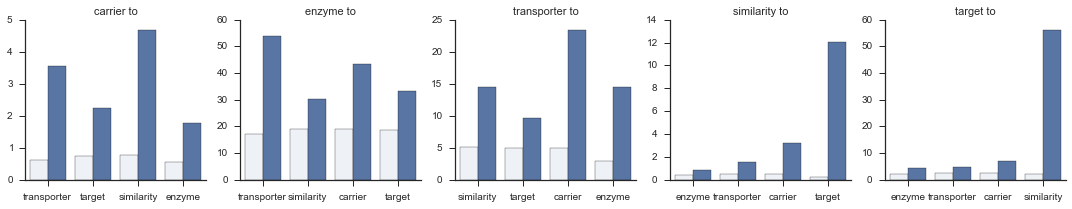

In [193]:
# Initialize a grid of plots with an Axes for each walk
new_categories=['carrier', 'enzyme', 'transporter', 'similarity', 'target']
grid = seaborn.FacetGrid(new_freq_df,  col="Type1", sharex="none", sharey="none")
grid= grid.map_dataframe(seaborn.barplot, x = 'Type2', y='contingency_relative_frequency', hue='T_or_F').set_titles("{col_name} to")
grid.savefig("output.png", dpi=200)